# Trading Strategy (HW3)
```@author Dennis Kuzminer```

# Install Required Libraries


In [1]:
import sys
# !pip uninstall -y numpy
# !pip uninstall -y setuptools
!{sys.executable} -m pip install mplfinance sparklines vectorbt scikit-learn selenium py-msci-esg numpy pandas html5lib beautifulsoup4 requests plotly --user 
!{sys.executable} -m pip3 install mplfinance sparklines vectorbt scikit-learn selenium py-msci-esg numpy pandas html5lib beautifulsoup4 requests plotly --user 
import pandas as pd
from sklearn.linear_model import LinearRegression
from bs4 import BeautifulSoup
import requests
import pickle 
import numpy as np
import vectorbt as vbt
import mplfinance as mpf
import html5lib

c:\Python310\python.exe: No module named pip3


# Scrape for S&P Constituents and Grab Wikipedia Page


In [2]:
request = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
soup = BeautifulSoup(request.content)
main_table = soup.find(id="constituents")
spy_data = pd.read_html(str(main_table))[0]
table = main_table.find("tbody").findAll("tr")
table = table[1:]
base_url = "https://en.wikipedia.org"
url_list = []
for item in table:
    url = base_url + str(item.findAll("a")[1]["href"])
    url_list.append(url)

spy_data["WIKI_URL"] = url_list
spy_data = spy_data[spy_data["Symbol"] != "POOL"].reset_index(drop=True)
spy_data


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,WIKI_URL
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,https://en.wikipedia.org/wiki/3M
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,https://en.wikipedia.org/wiki/A._O._Smith
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,https://en.wikipedia.org/wiki/Accenture
...,...,...,...,...,...,...,...,...,...
497,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997,https://en.wikipedia.org/wiki/Yum!_Brands
498,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969,https://en.wikipedia.org/wiki/Zebra_Technologies
499,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,https://en.wikipedia.org/wiki/Zimmer_Biomet
500,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873,https://en.wikipedia.org/wiki/Zions_Bancorpora...


In [29]:
!wget https://open-data.s3.filebase.com/rep_full.p

'wget' is not recognized as an internal or external command,
operable program or batch file.


# Ranking Companies

The goal here is to rank companies based on their ESG growth, not necessarily the current values, as we are interested in change over time to find companies with highest growth prospects. First, we will map/encode the dictionary of ESG ratings to a number. Then, we will reweigh the ratings such that ratings that are more recent bear more weight, as they are most representative of company's trajectory. Finally, we will run a linear regression and find the slope of the line of best fit. This way we can determine which companies have the fastest growth/lag. 

In [3]:
def weighted_average(data, alpha=0.9):
    weights = np.power(alpha, np.arange(len(data))[::-1])
    weighted_sum = np.sum(weights * data)
    weight_sum = np.sum(weights)
    return weighted_sum / weight_sum


def get_esg_risk(data):
    history = data.apply(
        lambda row: [*row["history"].values(), row["current"]["esg_rating"]]
        if isinstance(row["history"], dict)
        else np.nan,
        axis=1,
    )
    rep = {"ccc": 1, "b": 2, "bb": 3, "bbb": 4, "a": 5, "aa": 6, "aaa": 7}
    data["mapped_history"] = history.apply(
        lambda x: [rep[indiv_rating] for indiv_rating in x]
    )
    mapped = history.apply(
        lambda x: weighted_average([rep[indiv_rating] for indiv_rating in x])
    )
    return mapped


def get_esg_trend(history):
    x = np.arange(len(history)).reshape(-1, 1)
    model = LinearRegression().fit(x, history)
    slope = model.coef_[0]
    return slope


We must also be conscious of the data that has been provided. Most of the actual data from the ESG ranking file does not correlate with the actual S and P constituents; therefore, after looking through the data, I have determined that merging on the ticker is erroneous. Rather, we should use the company name. That is exactly what is done here: ```df["Security"] = df["rating-paragraph"].apply(lambda x: x.split(" is")[0])``` 

In [4]:
rep_full = pickle.load(open("rep_full.p", "rb"))
df = pd.DataFrame.from_dict(rep_full).T
df = df.dropna()
# The higher, the better
df["esg_risk"] = get_esg_risk(df)
df["esg_trend"] = df["mapped_history"].apply(lambda x: get_esg_trend(x))
df["Security"] = df["rating-paragraph"].apply(lambda x: x.split(" is")[0])
df = df.merge(spy_data, on="Security").drop_duplicates(subset=["Security"])


In [ ]:
# Scraper does not work anymore. The website has changed since the implementation of the scraper
# !pip install msci_esg


# Who lags the trend and who doesn't 

In [5]:
downward_trends = df[df["esg_trend"] < 0]
threshold = downward_trends["esg_trend"].quantile(0.25)
top_laggards = df[df["esg_trend"] < threshold].sort_values(by="esg_trend")
top_laggards


,rating-paragraph,rating-history-paragraph,current,history,mapped_history,esg_risk,esg_trend,Security,Symbol,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,WIKI_URL
56,Henry Schein is average among 46 companies in ...,"Henry Schein was downgraded in December, 2020.","{'esg_rating': 'bbb', 'esg_category': 'average'}","{'may-17': 'aaa', 'jun-18': 'aaa', 'apr-19': '...","[7, 7, 7, 7, 4, 4]",5.783504,-0.685714,Henry Schein,HSIC,Health Care,Health Care Distributors,"Melville, New York",2015-03-17,1000228,1932,https://en.wikipedia.org/wiki/Henry_Schein
65,IQVIA is average among 93 companies in the hea...,"IQVIA was downgraded in March, 2021.","{'esg_rating': 'bb', 'esg_category': 'average'}","{'dec-18': 'a', 'oct-19': 'a', 'feb-20': 'a', ...","[5, 5, 5, 4, 3, 3]",4.016132,-0.485714,IQVIA,IQV,Health Care,Life Sciences Tools & Services,"Durham, North Carolina",2017-08-29,1478242,1982,https://en.wikipedia.org/wiki/IQVIA
4,Accenture is average among 143 companies in th...,"Accenture was downgraded in December, 2020.","{'esg_rating': 'a', 'esg_category': 'average'}","{'jun-17': 'aaa', 'jun-18': 'aaa', 'mar-19': '...","[7, 7, 7, 7, 5, 5]",6.189003,-0.457143,Accenture,ACN,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,https://en.wikipedia.org/wiki/Accenture
19,ADP is average among 29 companies in the trans...,"ADP's rating remains unchanged since October, ...","{'esg_rating': 'a', 'esg_category': 'average'}","{'oct-16': 'aaa', 'oct-17': 'aa', 'oct-18': 'a...","[7, 6, 6, 5, 5, 5]",5.547654,-0.400000,ADP,ADP,Industrials,Human Resource & Employment Services,"Roseland, New Jersey",1981-03-31,8670,1949,https://en.wikipedia.org/wiki/ADP_(company)


Here, we determine whether it is better to hold a portfolio of equal weights of the top laggards or the top improvers for ESG ratings.

In [6]:
def get_stats(df):
    yahoo_url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1=1514782800&period2=1640926800&interval=1d&events=history"

    init_capital = 1e6
    position_returns = []
    rets = pd.DataFrame()

    for ticker in df["Symbol"]:
        url = yahoo_url.format(ticker)
        df_tmp = pd.read_csv(url)
        df_tmp["Date"] = pd.to_datetime(df_tmp["Date"])
        df_tmp.set_index("Date", inplace=True)
        rets[ticker] = df_tmp["Close"].pct_change()
        ret = (df_tmp.iloc[-1]["Close"] - df_tmp.iloc[0]["Open"]) / df_tmp.iloc[0][
            "Open"
        ]
        tot_return = (1 + ret) * (init_capital / len(df["Symbol"]))
        print(f"{ticker} gave {ret*100:.2f}%, returning {tot_return}")
        position_returns.append(tot_return)
        mpf.plot(
            df_tmp, type="candle", volume=True, warn_too_much_data=100000, title=ticker
        )

    avg_daily_return = rets.mean().mean()
    std_daily_return = rets.std().mean()
    sharpe_ratio = (avg_daily_return / std_daily_return) * np.sqrt(252)

    print(
        f"Portfolio return: {100*((sum(position_returns)-init_capital)/init_capital):.2f}% \
        \nAvg Daily Return: {avg_daily_return}\nVol: {std_daily_return}\nSharpe: {sharpe_ratio} \
        \nFinal Value: {sum(position_returns)}\nInit: {init_capital}"
    )


HSIC gave 41.25%, returning 353134.74943015963


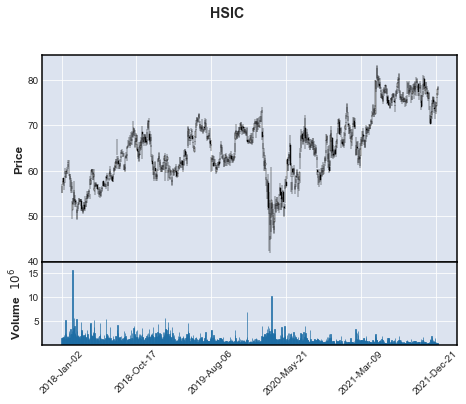

IQV gave 186.86%, returning 717138.6358243596


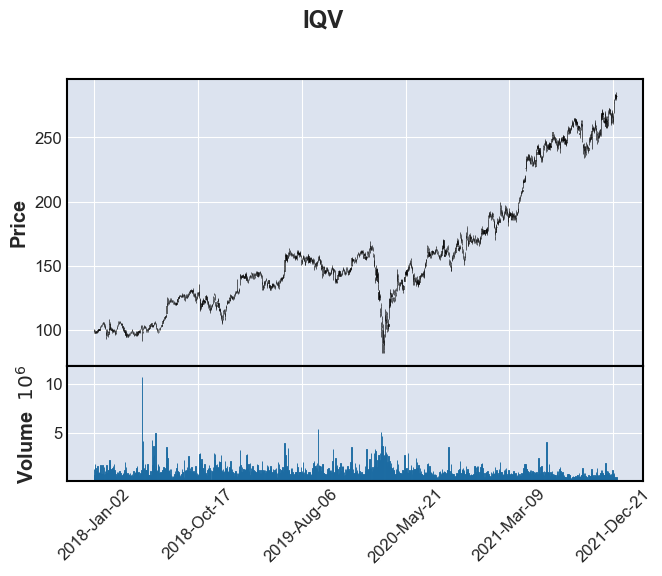

ACN gave 169.60%, returning 673990.2068403909


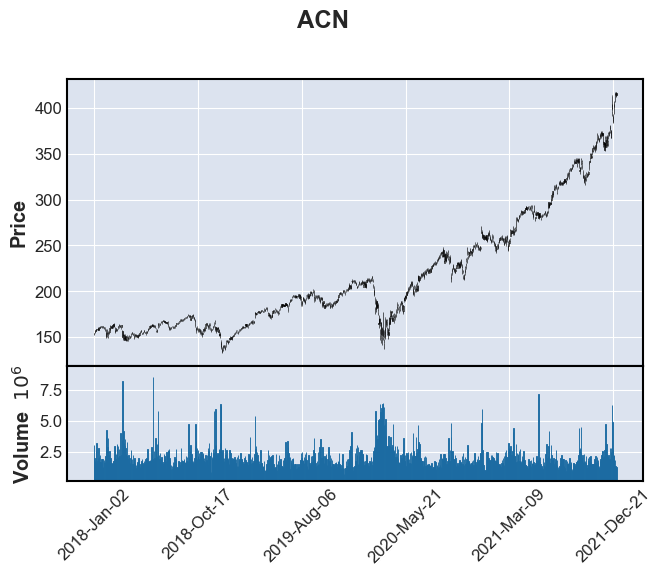

ADP gave 111.63%, returning 529087.3052580135


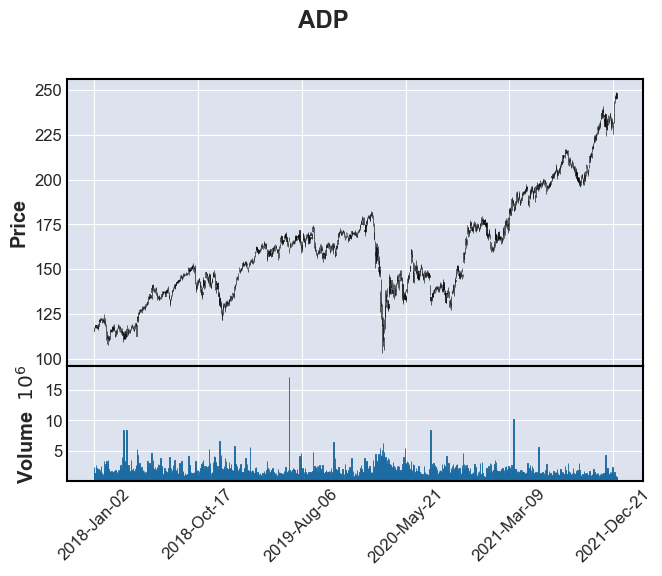

Portfolio return: 127.34%         
Avg Daily Return: 0.0009490445078189861
Vol: 0.018688096539261186
Sharpe: 0.8061609952235399         
Final Value: 2273350.8973529236
Init: 1000000.0


In [7]:
get_stats(top_laggards)


In [8]:
upward_trends = df[df["esg_trend"] > 0]
threshold = upward_trends["esg_trend"].quantile(0.9)
top_improvers = df[df["esg_trend"] > threshold].sort_values(
    by="esg_trend", ascending=False
)
top_improvers


,rating-paragraph,rating-history-paragraph,current,history,mapped_history,esg_risk,esg_trend,Security,Symbol,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,WIKI_URL
58,Huntington Bancshares is a leader among 196 co...,Huntington Bancshares was upgraded in December...,"{'esg_rating': 'aa', 'esg_category': 'leader'}","{'oct-17': 'bb', 'oct-18': 'bb', 'sep-19': 'bb...","[3, 3, 3, 4, 6, 6]",4.389366,0.714286,Huntington Bancshares,HBAN,Financials,Regional Banks,"Columbus, Ohio; Detroit, Michigan",1997-08-28,49196,1866,https://en.wikipedia.org/wiki/Huntington_Bancs...
44,Equifax is average among 20 companies in the p...,"Equifax was upgraded in March, 2021.","{'esg_rating': 'bbb', 'esg_category': 'average'}","{'apr-17': 'ccc', 'apr-18': 'ccc', 'aug-19': '...","[1, 1, 3, 3, 4, 4]",2.873403,0.685714,Equifax,EFX,Industrials,Research & Consulting Services,"Atlanta, Georgia",1997-06-19,33185,1899,https://en.wikipedia.org/wiki/Equifax
91,Pentair is average among 51 companies in the i...,"Pentair was upgraded in February, 2021.","{'esg_rating': 'a', 'esg_category': 'average'}","{'feb-17': 'b', 'feb-18': 'bb', 'mar-19': 'bbb...","[2, 3, 4, 4, 5, 5]",4.013428,0.600000,Pentair,PNR,Industrials,Industrial Machinery & Supplies & Components,"Worsley, United Kingdom",2012-10-01,77360,1966,https://en.wikipedia.org/wiki/Pentair
79,MetLife is average among 46 companies in the l...,"MetLife was upgraded in December, 2020.","{'esg_rating': 'a', 'esg_category': 'average'}","{'may-17': 'bb', 'dec-17': 'b', 'jun-18': 'b',...","[3, 2, 2, 3, 5, 5]",3.515389,0.571429,MetLife,MET,Financials,Life & Health Insurance,"New York City, New York",2000-12-11,1099219,1868,https://en.wikipedia.org/wiki/MetLife


HBAN gave 4.89%, returning 262236.5737593474


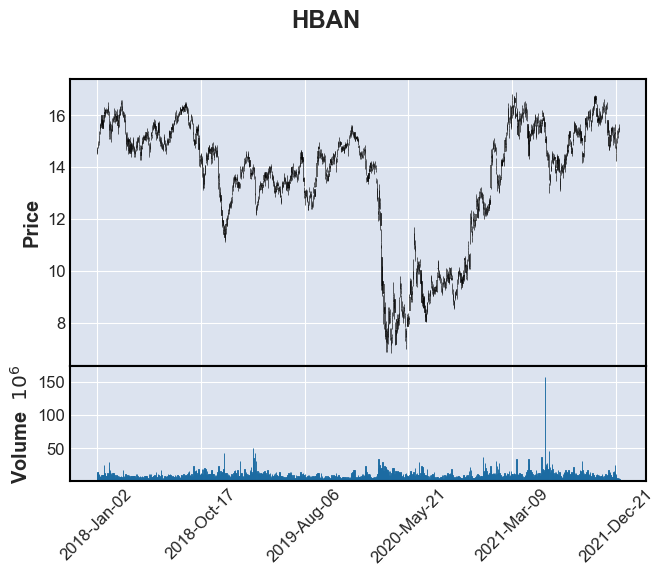

EFX gave 146.71%, returning 616780.9383393574


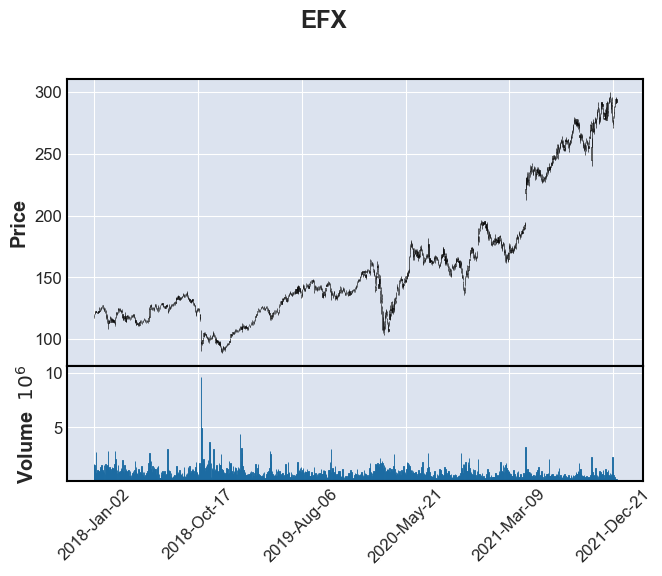

PNR gave 51.67%, returning 379170.694131935


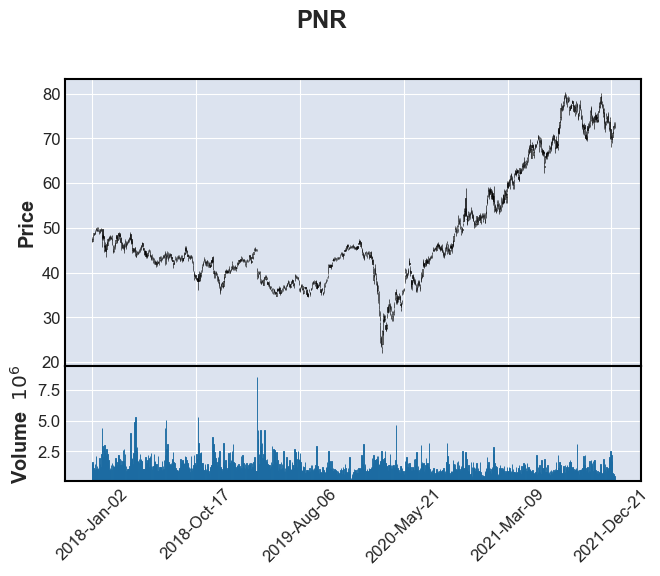

MET gave 23.16%, returning 307911.8321607591


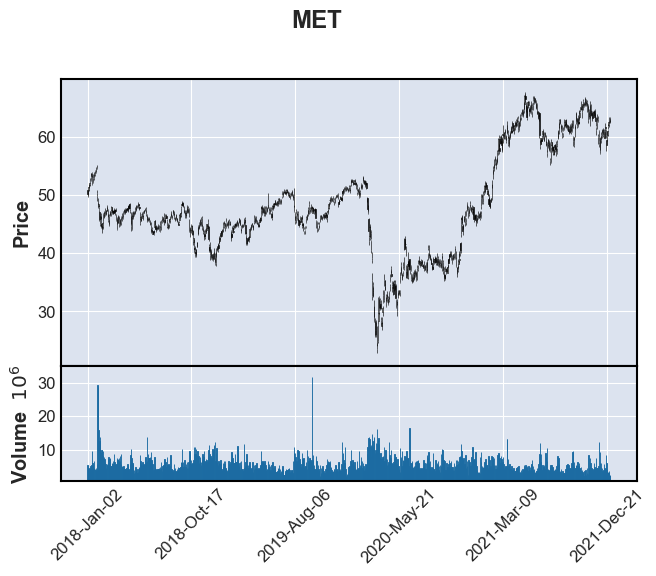

Portfolio return: 56.61%         
Avg Daily Return: 0.0006401888063369131
Vol: 0.021919776274764505
Sharpe: 0.4636307467183655         
Final Value: 1566100.0383913987
Init: 1000000.0


In [9]:
get_stats(top_improvers)


We can see that (surprisingly... or maybe not) from the top percentage of growers and laggards in ESG of S and P constituents, the risk-return profile of the laggards actually tends to be better.  
It may also be true that better ESG scores just don't really tend to boost share price: https://hbr.org/2022/03/an-inconvenient-truth-about-esg-investing